<a href="https://colab.research.google.com/github/naenumtou/ifrs9/blob/main/PD/SilhouetteAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.special import logit
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import zscore

# Config
%config InlineBackend.figure_format = 'retina' #Retina display
plt.style.use('seaborn-deep') #Plot style

In [3]:
# Import dependence variable
odr = pd.read_csv(
    'https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/monthlyODR.csv'
)

# Select segment, drop columns
odr = odr.query(
    "Segment == 'CU'"
).drop(
    ['Segment', 'Monthkey'],
    axis = 1
).eval(
    "ODR = Bad / N"
)

# Transform to logit
odr['logitODR'] = logit(odr['ODR'])

# Import macroeconomics data
mev = pd.read_csv(
    'https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/macroTransformed.csv'
)

# Assign date to dependence variable
odr['Date'] = mev['Date']
odr.head(5)

,N,Bad,ODR,logitODR,Date
0,21556,815.0,0.037808,-3.236680,2014-01-01
1,21794,885.0,0.040608,-3.162347,2014-02-01
2,21911,920.0,0.041988,-3.127475,2014-03-01
3,22128,960.0,0.043384,-3.093313,2014-04-01
4,22115,989.0,0.044721,-3.061565,2014-05-01


In [4]:
# Mapping with logit ODR
df = pd.merge(
    odr[['Date', 'logitODR']],
    mev,
    how = 'left',
    left_on = ['Date'],
    right_on = ['Date']
)
df = df.set_index('Date')
df.head(5)

,logitODR,FDI,HD,GDP,RSI,CPI,Wage,UR,OP,Im,Ex,PCI,CCI,API,PII,MPI,PIR,FDI_LN,HD_LN,GDP_LN,RSI_LN,CPI_LN,Wage_LN,UR_LN,OP_LN,Im_LN,Ex_LN,PCI_LN,CCI_LN,API_LN,PII_LN,MPI_LN,PIR_LN,FDI_M3,FDI_M6,FDI_M9,FDI_M12,HD_M3,HD_M6,HD_M9,...,CCI_C_lg9,CCI_C_lg10,CCI_C_lg11,CCI_C_lg12,API_C_lg1,API_C_lg2,API_C_lg3,API_C_lg4,API_C_lg5,API_C_lg6,API_C_lg7,API_C_lg8,API_C_lg9,API_C_lg10,API_C_lg11,API_C_lg12,PII_C_lg1,PII_C_lg2,PII_C_lg3,PII_C_lg4,PII_C_lg5,PII_C_lg6,PII_C_lg7,PII_C_lg8,PII_C_lg9,PII_C_lg10,PII_C_lg11,PII_C_lg12,MPI_C_lg1,MPI_C_lg2,MPI_C_lg3,MPI_C_lg4,MPI_C_lg5,MPI_C_lg6,MPI_C_lg7,MPI_C_lg8,MPI_C_lg9,MPI_C_lg10,MPI_C_lg11,MPI_C_lg12
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-01,-3.236680,189417.136534,8.560335e+06,2.381830e+06,212.76,100.15,12911.24,0.94,107.42,637677.49,587085.59,111.37,29.5,150.804689,121.98,100.073269,2.25,12.151707,15.962650,14.683380,5.360165,4.606669,9.465854,-0.061875,4.676746,13.365588,13.282926,4.712858,3.384390,5.015986,4.803857,4.605903,0.810930,188385.514044,189952.931678,189814.358032,190734.781579,8.509564e+06,8.388654e+06,8.280323e+06,...,0.551944,0.499457,0.227784,0.313181,0.033815,-0.006416,-0.012409,0.010903,0.018121,-0.011507,0.006890,-0.005963,-0.042972,-0.053358,-0.052771,-0.041031,-0.021557,-0.025671,-0.026563,-0.006897,-0.015199,-0.022686,-0.043988,-0.038724,0.004171,-0.000974,0.029274,0.151198,-0.093903,-0.102690,-0.061016,-0.028748,-0.013185,-0.008389,0.025905,0.046398,0.089870,0.143477,0.119307,0.239164
2014-02-01,-3.162347,193355.095090,8.576515e+06,2.397283e+06,206.74,100.39,12809.44,0.86,108.81,488289.38,598571.15,102.51,26.7,145.387932,118.41,100.594662,2.25,12.172284,15.964538,14.689847,5.331462,4.609063,9.457938,-0.150823,4.689603,13.098664,13.302301,4.629960,3.284664,4.979406,4.774153,4.611099,0.810930,190038.653875,190305.154152,190079.124929,190886.367688,8.552638e+06,8.452922e+06,8.345568e+06,...,0.380833,0.551944,0.499457,0.227784,0.000948,0.033815,-0.006416,-0.012409,0.010903,0.018121,-0.011507,0.006890,-0.005963,-0.042972,-0.053358,-0.052771,-0.016424,-0.021557,-0.025671,-0.026563,-0.006897,-0.015199,-0.022686,-0.043988,-0.038724,0.004171,-0.000974,0.029274,-0.116277,-0.093903,-0.102690,-0.061016,-0.028748,-0.013185,-0.008389,0.025905,0.046398,0.089870,0.143477,0.119307
2014-03-01,-3.127475,196757.890000,8.589811e+06,2.386443e+06,231.55,100.60,12633.14,0.88,107.40,553252.08,641085.67,118.68,27.5,146.000067,131.07,109.942282,2.00,12.189729,15.966087,14.685315,5.444796,4.611152,9.444079,-0.127833,4.676560,13.223569,13.370918,4.776431,3.314186,4.983607,4.875732,4.699956,0.693147,193176.707208,191032.969152,190993.494929,191044.206021,8.575554e+06,8.507640e+06,8.403359e+06,...,0.348307,0.380833,0.551944,0.499457,-0.027885,0.000948,0.033815,-0.006416,-0.012409,0.010903,0.018121,-0.011507,0.006890,-0.005963,-0.042972,-0.053358,-0.006985,-0.016424,-0.021557,-0.025671,-0.026563,-0.006897,-0.015199,-0.022686,-0.043988,-0.038724,0.004171,-0.000974,-0.058933,-0.116277,-0.093903,-0.102690,-0.061016,-0.028748,-0.013185,-0.008389,0.025905,0.046398,0.089870,0.143477
2014-04-01,-3.093313,198952.610990,8.618880e+06,2.346222e+06,205.79,101.10,13219.29,0.90,107.79,559413.50,556218.79,116.48,29.8,142.590361,119.25,89.339924,2.00,12.200822,15.969466,14.668317,5.326856,4.616110,9.489432,-0.105361,4.680185,13.234644,13.228917,4.757720,3.394508,4.959976,4.781222,4.492448,0.693147,196355.198693,192370.356369,192087.020683,191449.568197,8.595069e+06,8.552316e+06,8.457459e+06,...,0.240180,0.348307,0.380833,0.551944,-0.017446,-0.027885,0.000948,0.033815,-0.006416,-0.012409,0.010903,0.018121,-0.011507,0.006890,-0.005963,-0.042972,-0.018145,-0.006985,-0.016424,-0.021557,-0.025671,-0.026563,-0.006897,-0.015199,-0.022686,-0.043988,-0.038724,0.004171,-0.088659,-0.058933,-0.116277,-0.093903,-0.102690,-0.061016,-0.028748,-0.013185,-0.008389,0.025905,0.046398,0.089870
2014-05-01,-3.061565,200103.269226,8.659787e+06,2.292120e+06,214.25,101.51,13264.39,0.94,1

In [5]:
# Find top 30 by correlation analysis
n = 30
dfCorr = df.corr()

selected = abs(
    dfCorr['logitODR']
).sort_values(
    ascending = False
)[:n].index[1:] #Without 'logitODR'

# Selected DataFrame
df = df[selected]
df.head(5)

,GDP_C_lg12,GDP_C_lg11,MPI_C_lg12,MPI_C_lg11,GDP_C_lg10,RSI_C_lg12,MPI_C_lg10,PCI_C_lg12,PII_M12_lg11,OP_C,PII_M12_lg12,RSI_C_lg11,PII_M12_lg10,GDP_C_lg9,CPI_C,OP_C_lg1,RSI_C_lg10,PII_M12_lg9,API_C_lg8,API_C_lg9,OP_C_lg2,CPI_M9_lg6,CPI_M9_lg5,MPI_C_lg9,API_C_lg7,PIR_C_lg12,CPI_M12_lg4,CPI_M6_lg8,CPI_M6_lg7
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-01,0.125214,0.086355,0.239164,0.119307,0.052505,0.165824,0.143477,0.081950,132.205833,-0.050376,131.919167,0.043697,132.195000,0.032748,0.019154,0.008986,0.080085,132.236667,-0.005963,-0.042972,-0.014969,98.541111,98.702222,0.089870,0.006890,-0.25,98.617500,98.486667,98.650000
2014-02-01,0.086355,0.052505,0.119307,0.143477,0.032748,0.043697,0.089870,0.029768,132.195000,-0.068460,132.205833,0.080085,132.236667,0.026525,0.019412,-0.050376,0.073149,131.815833,0.006890,-0.005963,0.008986,98.702222,98.838889,0.046398,-0.011507,-0.25,98.736667,98.650000,98.803333
2014-03-01,0.052505,0.032748,0.143477,0.089870,0.026525,0.080085,0.046398,0.056690,132.236667,-0.016987,132.195000,0.073149,131.815833,0.026890,0.020893,-0.068460,0.021928,131.337500,-0.011507,0.006890,-0.050376,98.838889,98.976667,0.025905,0.018121,-0.25,98.893333,98.803333,98.920000
2014-04-01,0.032748,0.026525,0.089870,0.046398,0.026890,0.073149,0.025905,0.041751,131.815833,0.046622,132.236667,0.021928,131.337500,0.028179,0.024228,-0.016987,-0.006852,131.095833,0.018121,-0.011507,-0.068460,98.976667,99.102222,-0.008389,0.010903,-0.25,99.030000,98.920000,99.053333
2014-05-01,0.026525,0.026890,0.046398,0.025905,0.028179,0.021928,-0.008389,0.021510,131.337500,0.062547,131.815833,-0.006852,131.095833,0.027953,0.025846,0.046622,-0.041621,130.935000,0.010903,0.018121,-0.016987,99.102222,99.236667,-0.013185,-0.012409,-0.50,99.188333,99.053333,99.188333


In [6]:
# Data preprocessing
# Standardisation
scalar = StandardScaler()
dfSTD = pd.DataFrame(
    scalar.fit_transform(df),
    columns = df.columns
).T #Transpose
dfSTD.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58
GDP_C_lg12,4.888266,2.899922,1.167917,0.156947,-0.161447,-0.142773,-0.076814,-0.088398,-0.260362,-0.609233,-1.044134,-1.414253,-1.658347,-1.752543,-1.708844,-1.526644,-1.290480,-1.092074,-1.027007,-1.023477,-0.968274,-0.789617,-0.533926,-0.295499,-0.114148,-0.006390,0.027776,0.002266,-0.041753,-0.046396,0.030856,0.145368,0.215445,0.189859,0.112255,0.048814,0.039933,0.088174,0.159950,0.265673,0.359246,0.389015,0.313163,0.181236,0.081433,0.075488,0.131843,0.198165,0.245077,0.279518,0.330156,0.413809,0.508769,0.605870,0.679750,0.711433,0.674309,0.573553,0.481580
GDP_C_lg11,3.861097,1.612837,0.300530,-0.112767,-0.088527,-0.002907,-0.017944,-0.241165,-0.694023,-1.258555,-1.738994,-2.055844,-2.178117,-2.121393,-1.884884,-1.578328,-1.320783,-1.236322,-1.231740,-1.160083,-0.928174,-0.596270,-0.286775,-0.051370,0.088507,0.132857,0.099743,0.042604,0.036576,0.136855,0.285500,0.376464,0.343252,0.242517,0.160166,0.148637,0.211258,0.304428,0.441664,0.563127,0.601770,0.503309,0.332058,0.202508,0.194790,0.267944,0.354034,0.414928,0.459635,0.525367,0.633954,0.757219,0.883262,0.979164,1.020290,0.972100,0.841313,0.721926,0.730773
MPI_C_lg12,4.160491,2.069820,2.491427,1.556360,0.798076,0.440616,-0.157589,-0.241241,-0.512700,-1.075553,-1.802470,-1.649206,-2.039482,-1.039217,-1.557734,-0.905151,-1.111803,-1.261488,-1.070359,-1.051339,-0.751583,-0.414648,-0.322763,0.567812,0.549536,0.565381,-0.012445,0.013004,-0.336799,0.218750,0.006479,0.188394,-0.114956,-0.512735,-0.205119,-0.305284,-0.635759,-0.222838,0.215938,0.311048,0.103692,0.457100,-0.165668,0.814245,0.930360,-0.003639,0.269028,0.295523,0.250046,-0.331063,0.247144,-0.283457,0.422238,-0.051014,0.264661,0.555770,0.151867,0.208368,1.021929
MPI_C_lg11,2.518157,3.017261,1.910317,1.012653,0.589489,-0.118673,-0.217702,-0.539058,-1.205369,-2.065901,-1.884466,-2.346478,-1.162354,-1.776180,-1.003645,-1.248283,-1.425480,-1.199220,-1.176704,-0.821850,-0.422983,-0.314209,0.740064,0.718429,0.737186,0.053150,0.083277,-0.330824,0.326840,0.075552,0.290905,-0.068204,-0.539099,-0.174940,-0.293516,-0.684737,-0.195915,0.323512,0.436104,0.190634,0.609002,-0.128237,1.031794,1.169253,0.063575,0.386360,0.417726,0.363889,-0.324034,0.360454,-0.267677,0.567732,0.007491,0.381191,0.725808,0.247664,0.314551,1.277652,0.988068
GDP_C_lg10,1.907930,0.401977,-0.072307,-0.044491,0.053763,0.036508,-0.219652,-0.739335,-1.387170,-1.938503,-2.302109,-2.442424,-2.377330,-2.105921,-1.754129,-1.458581,-1.361656,-1.356398,-1.274167,-1.008037,-0.627158,-0.271993,-0.001850,0.158667,0.209562,0.171561,0.105991,0.099073,0.214149,0.384729,0.489115,0.451003,0.335402,0.240900,0.227670,0.299531,0.406450,0.563936,0.703323,0.747667,0.634678,0.438157,0.289490,0.280633,0.364581,0.463375,0.533256,0.584559,0.659991,0.784600,0.926055,1.070698,1.180751,1.227945,1.172645,1.022558,0.885554,0.895706,1.119074


### Silhouette anaylsis
The silhouette method is a method to find the optimal number of clusters and interpretation and validation of consistency within clusters of data. The silhouette method computes silhouette coefficients of each point that measure how much a point is similar to its own cluster compared to other clusters. by providing a succinct graphical representation of how well each object has been classified.

The silhouette value is a measure of how similar an object is to its own cluster compared to other clusters. The value of the silhouette ranges between `[1, -1]`, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

In [7]:
# Silhouette analysis
SS = []

for n in range(2, dfSTD.shape[0]):
  KM = KMeans(n_clusters = n)
  KM.fit(dfSTD)
  SS.append(
      [n, silhouette_score(dfSTD, KM.labels_).round(4)]
  )

SS = pd.DataFrame(
    SS,
    columns = ['Number of cluster', 'Silhouette score']
)

SS.head(5)

,Number of cluster,Silhouette score
0,2,0.4865
1,3,0.4559
2,4,0.4016
3,5,0.3777
4,6,0.3674


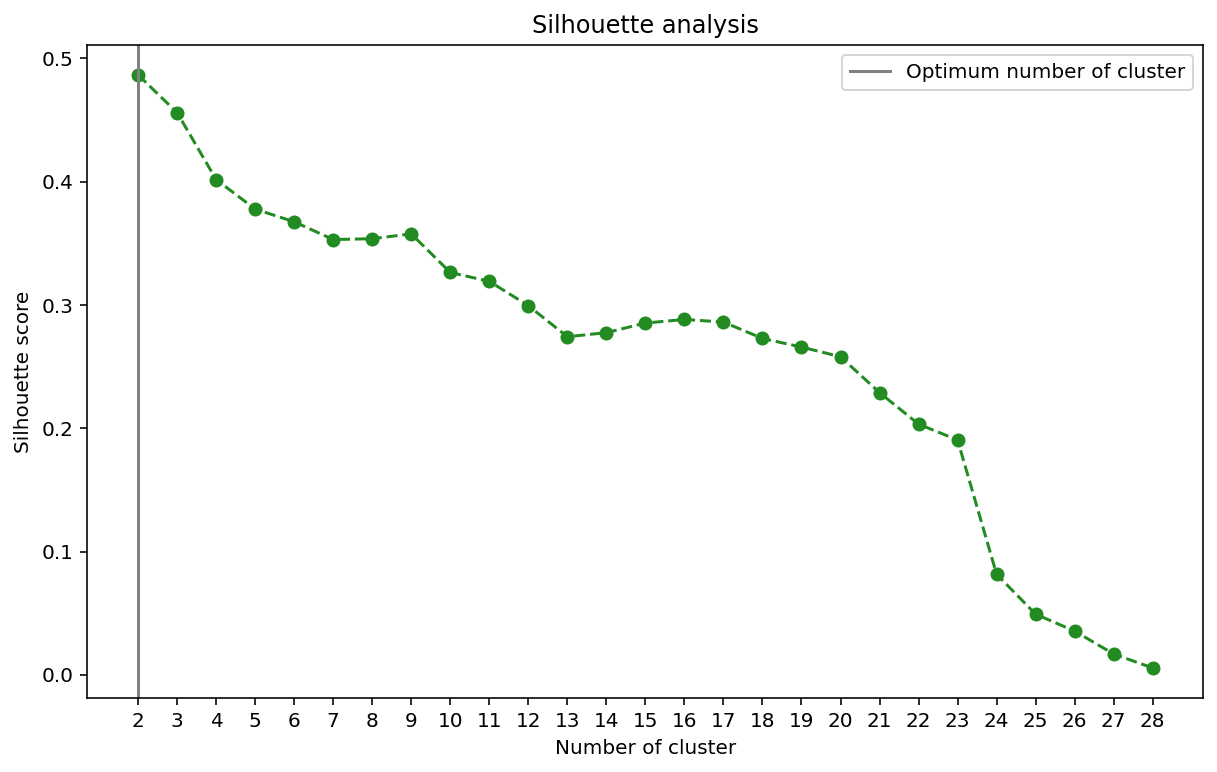

In [8]:
# Plot
plt.figure(figsize = (10, 6))
plt.plot(
    SS['Silhouette score'],
    c = 'forestgreen',
    linestyle = '--',
    marker = 'o'
)
plt.axvline(
    x = SS['Silhouette score'].idxmax(),
    c = 'gray',
    label = 'Optimum number of cluster'
)
plt.xticks(
    np.arange(SS.shape[0]),
    SS['Number of cluster']
)
plt.title('Silhouette analysis')
plt.xlabel('Number of cluster')
plt.ylabel('Silhouette score')
plt.legend(
      frameon = True,
      facecolor = 'white'
)
plt.show()

In [9]:
# K-Means clustering
KM = KMeans(n_clusters = 2)
KM.fit(dfSTD)

KMeans(n_clusters=2)

In [10]:
# Cluster result
dfSTD['Cluster'] = KM.labels_ + 1

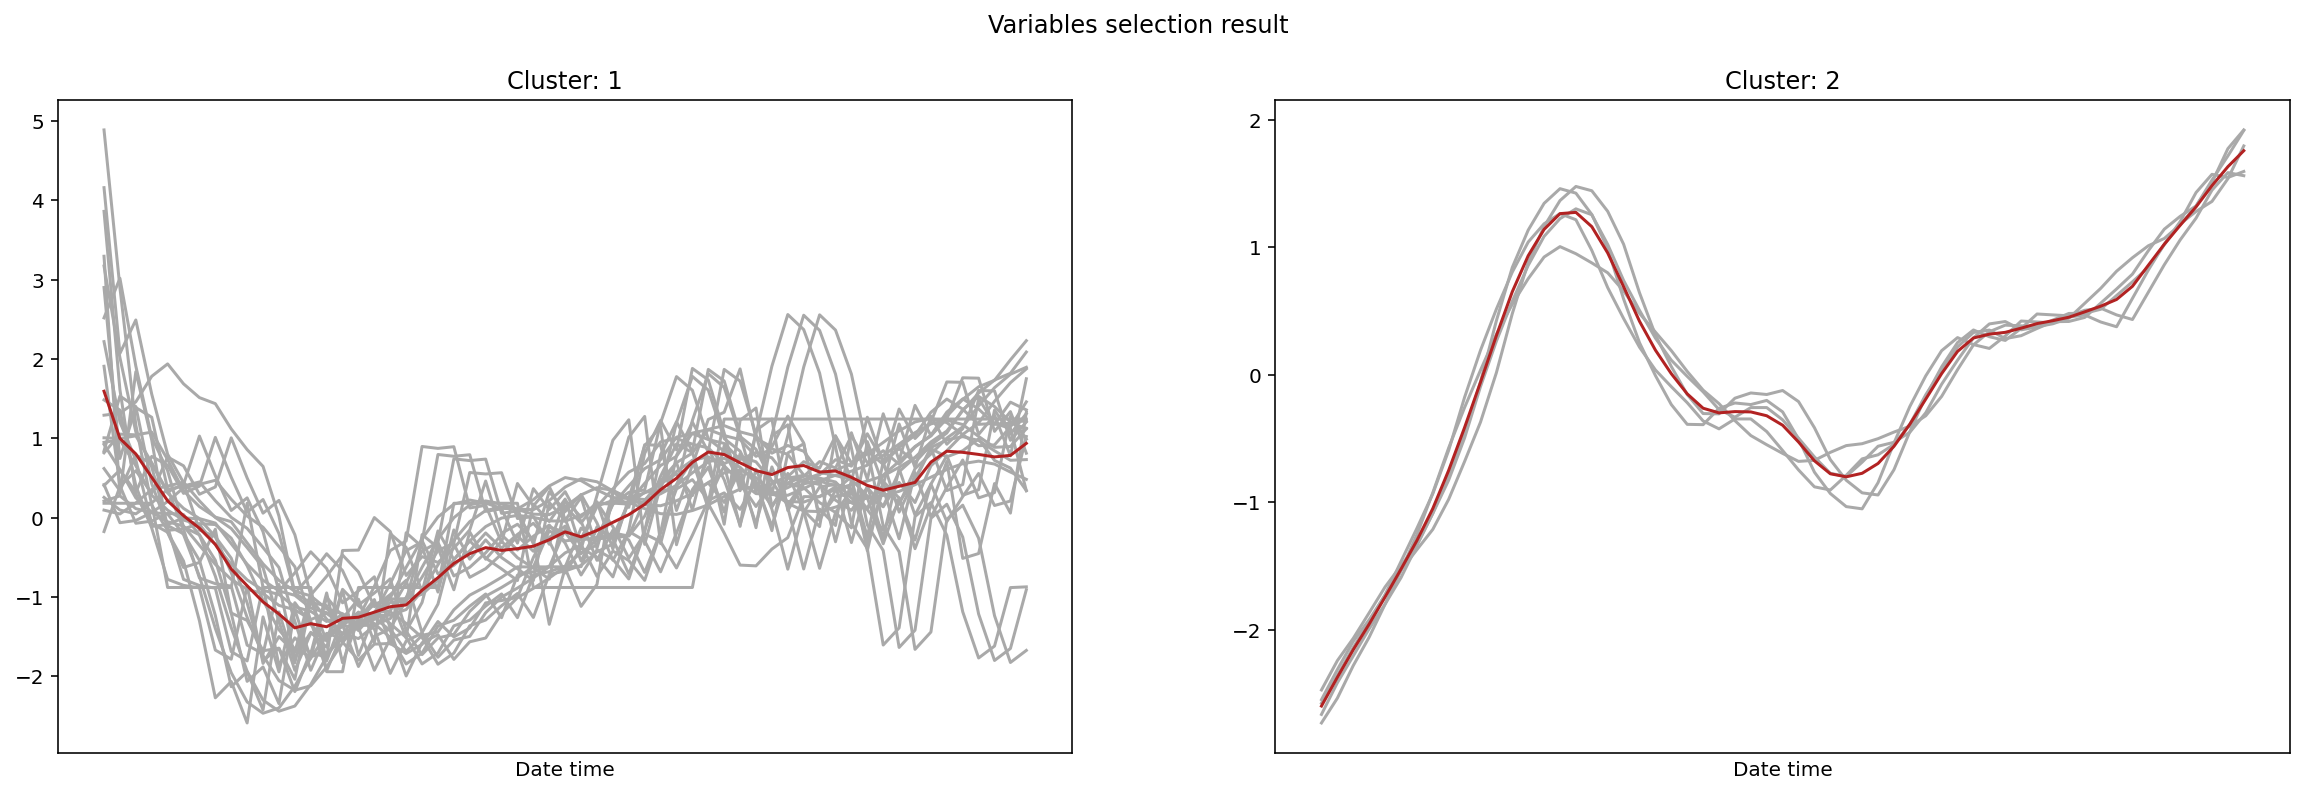

In [11]:
# Plot
fig, axs = plt.subplots(
    1, 2,
    figsize = (20, 6), 
    sharex = True
)
axs = axs.ravel()
fig.suptitle('Variables selection result')
for cluster in sorted(dfSTD['Cluster'].unique()):
  dataPlot = dfSTD.query(
      "Cluster == @cluster"
  ).drop(
      ['Cluster'],
      axis = 1
  ).T
  dataMeanPlot = dataPlot.mean(axis = 1)
  axs[cluster - 1].plot(dataPlot, color = 'darkgray')
  axs[cluster - 1].plot(dataMeanPlot, color = 'firebrick')
  axs[cluster - 1].set_title(f'Cluster: {cluster}')
  axs[cluster - 1].set_xticks([])
  axs[cluster - 1].set(xlabel = 'Date time', ylabel = '')
plt.show()